#***Proyecto Team Stress***

# 1. Introducción

#2. Objetivo del estudio

El objetivo del estudio es determinar qué factores influyen en el estrés de un empleado. Para ello utilizaremos una de las preguntas incluidas en el Dataset "Scores": "**On a scale from 1 to 10, how would you rate the work-related stress?**". 

Vamos a definir cuándo consideramos que un empleado está estresado y cómo ha respondido con anterioridad a las preguntas planteadas por la aplicación.

#3. Tratamiento de datos

###3.1. Carga de librerias

In [133]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

# creamos una función que nos permita ver más registros del dataset
def display_all(df):
    with pd.option_context("display.max_rows", 2000, "display.max_columns", 1000): 
        display(df)

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###3.2. Cargamos los datos extraídos de la app HappyForce.
Por una parte tenemos un fichero con la puntuación del Hapyness Index y por otra parte tenemos las respuestas a las distintas preguntas que se realizan en la aplicación a lo largo de la semana.

In [135]:
scores = pd.read_csv('/content/drive/My Drive/TeamStress Project/scores.csv')
hi = pd.read_csv('/content/drive/My Drive/TeamStress Project/hi.csv')

Revisamos estructura de datos

In [136]:
scores.shape

(285512, 11)

In [137]:
scores.head()

,companyAlias,companyIndustry,scoreId,scoreName,factorId,factorName,questionId,questionTitle,employeeId,date,vote
0,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",qNd,20/09/2019,8
1,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",5gm,20/09/2019,8
2,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",QXd,20/09/2019,8
3,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",r6g,20/09/2019,10
4,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",z82,20/09/2019,10


El dataset "scores" está estructurado de forma que cada registro representa la respuesta de un empleado a una pregunta determinada. Para cada registro tenemos las variables suficientes para identificar la compañia, el sector al que pertenece la compañia, el id de la pregunta, el id del factor al que se asocia la pregunta y la fecha en la que se responde a la pregunta, además de la puntuación asignada por el empleado (de 1 a 10).

In [138]:
hi.shape

(2364507, 5)

In [139]:
hi.head()

,companyAlias,companyIndustry,employeeId,date,vote
0,5ad7d22a40bbc80004b73727,MANUFACTURING,07,19/04/2018,1
1,5ad7d22a40bbc80004b73727,MANUFACTURING,kyQ,19/04/2018,3
2,5ad7d22a40bbc80004b73727,MANUFACTURING,y5w,19/04/2018,3
3,5ad7d22a40bbc80004b73727,MANUFACTURING,p1L,19/04/2018,3
4,5ad7d22a40bbc80004b73727,MANUFACTURING,bJ7,19/04/2018,3


El dataset "hi" contiene las respuestas al Happyness Index. Cada registro representa un voto de un empleado en una fecha determinada. Los valores del HI van del 1 al 4, siendo 4 la valoración más positiva.

###3.3. Construcción dataframe para modelizar

Para poder trabajar con las respuestas de cada empleado, necesitaremos crear un dataset en el que tengamos, para cada registro, toda la información relativa a un período anterior a la fecha en la que el empleado responde a la pregunta de estrés.

**Limpiamos el dataframe Scores**

Empezamos revisando si el dataset tiene duplicados.

In [140]:
scores.shape

(285512, 11)

In [141]:
scores.drop_duplicates(inplace = True);
scores.shape

(103330, 11)

Si comparamos con el "shape" antes y después de eliminar los duplicados, vemos como teníamos casi un tercio del dataset "scores" con registros duplicados

In [142]:
hi.shape

(2364507, 5)

In [143]:
hi.drop_duplicates(inplace = True);
hi.shape

(847935, 5)

Con el dataset "hi" nos ocurre lo mismo que con el anterior. En este caso, eliminando duplicados nos quedamos sólo con un tercio de la muestra.

Para que sea más cómodo trabajar con el dataframe, factorizamos el ID de las preguntas. De esta forma evitamos tener que tratar con el ID complejo que tienen asignados en el Dataset y trabajaremos con identificadores numéricos consecutivos. Esto nos facilitará la nomenclatura de las variables relativas a cada pregunta/factor.

In [144]:
scores['questionNumber'] = pd.factorize(scores['questionId'])[0]
scores['factorNumber'] = pd.factorize(scores['factorId'])[0]

Mostramos la codificación de preguntas y factores

In [342]:
pd.set_option('display.max_colwidth', -1)
scores[['questionNumber','factorNumber','questionTitle','factorName']].drop_duplicates().reset_index(drop=True)
questions

,questionNumber,factorNumber,questionTitle,factorName
0,0,0,"On a scale from 1 to 10, how likely are you to recommend *|COMPANY_NAME|* as good place to work?",eNPS
1,1,1,"On a scale of 1 to 10, how comfortable do you feel giving upwards feedback to your manager?",Diversity of Opinion
2,2,1,I feel like I can voice my opinion regarding *|COMPANY_NAME|*:,Diversity of Opinion
3,3,1,"My teammates, welcome opinions different from their own.",Diversity of Opinion
4,4,2,*|COMPANY_NAME|* communicates in a clear and effective way us.,Quality & Frequency
5,5,2,My manager communicates openly and honestly with me.,Quality & Frequency
6,6,2,Which of the following best describes the amount of feedback you typically get regarding your work,Quality & Frequency
7,7,3,*|COMPANY_NAME|* seem to valuate my opinions and suggestions.,Active Listening
8,8,3,My manager embraces my opinions,Active Listening
9,9,3,"From 1 to 10, how would you rate how your co-workers and peers welcome your opinions?",Active Listening


**Variable Objetivo**

A continuación trataremos la variable objetivo para que sea el punto de partida del análisis. 

En el análisis sólo entrarán los empleados que hayan respondido a la pregunta de estrés. Preparamos un dataframe con estos empleados.

In [146]:
stressQuestionId = '5dd6e4a49a5137000450ff1d'
stressScores = scores[scores['questionId']==stressQuestionId]

In [147]:
stressScores.shape

(1885, 13)

En total tenemos 1885 votos en la pregunta de estrés

**Analisis la distribución de votos**

In [148]:
stressScores['vote'].value_counts().to_frame().style.bar()

,vote
3,495
4,401
2,251
1,197
5,188
6,149
7,82
8,68
9,34
10,20


In [149]:
stressScores['vote'].value_counts(sorted)

3     0.262599
4     0.212732
2     0.133156
1     0.104509
5     0.099735
6     0.079045
7     0.043501
8     0.036074
9     0.018037
10    0.010610
Name: vote, dtype: float64

In [150]:
print('Porcentaje malos: {:.2%}'.format(len(stressScores[stressScores['vote']<=3])/len(stressScores)))

Porcentaje malos: 50.03%


En la base de datos de Happy Force, se invirtió la puntuación de la pregunta para ir alineado con el resto de preguntas. De esta forma, una puntuación baja significa elevado nivel de estrés y viceversa. 

Si analizamos la distribución, vemos que tenemos un 50% de empleados que responden a la pregunta con puntuaciones inferiores o iguales a 3. Consideraremos estas puntuaciones para definir el estrés.

**Tratamiento fechas**

Cambiamos todas las variables que se refieren a fechas a un formato datetime para que Python las trate correctamente.

In [151]:
hi['date'] = pd.to_datetime(hi['date'])
stressScores['date'] = pd.to_datetime(stressScores['date'])
scores['date'] = pd.to_datetime(scores['date'])

**Creamos un diccionario de preguntas**

Para tratar correctamente todas las preguntas que tenemos en el dataset, vamos a crear diccionarios con cada una de las preguntas para tenerlas como datasets separados.

In [152]:
questionNumber = scores['questionNumber'].nunique()

df_questions = {}

for i in range(questionNumber):
  df_questions[i]  = scores[scores['questionNumber'] == i]

**Creamos un diccionario de factores**

Para los factores (grupos de preguntas), hacemos el mismo tratamiento que hemos hecho para las preguntas, agrupando en un diccionarios todos los valores para cada factor.

In [153]:
factorNumber = scores['factorId'].nunique()

df_factors = {}

for i in range(factorNumber):
  df_factors[i]  = scores[scores['factorNumber'] == i]

A continuación definimos la función que nos construirá el dataset que necesitamos para modelizar.

La función utiliza como base el dataset generado con las preguntas de estrés ("stressScores") y añade, para cada empleado y fecha de pregunta de estrés, un promedio de la ventana temporal (anterior a la respuesta de estrés) que le indiquemos.

De esta forma podemos crear una variable para cada pregunta y/o factor que nos va a indicar el valor promedio de las respuestas del empleado en los meses anteriores que deseemos.

Hemos implementado la función de forma que si no se indica ninguna ventana ("window"), selecciona por defecto los "month" meses anteriores, mientras que si asignamos un valor a "window" nos calcula el promedio de hace "month" meses durante "window" mes. Esto nos permite anticiparnos al estrés utilizando variables que muestran qué puntuación tiene una pregunta 6 meses antes de que el empleado diga que está estresado. 

**// A esta explicación hay que darle una vuelta más //**

In [154]:
def build_stress_historic(df, stress_df, sfx, months, window=99):
  # Calculamos la fecha desde la cual queremos obtener la puntuación por empleado:
  stress_df['fromDate'] = pd.to_datetime(stressScores['date']) - pd.DateOffset(months=months)
  if window==99:
    stress_df['toDate'] = pd.to_datetime(stress_df['date'])
  else:
    stress_df['toDate'] = pd.to_datetime(stress_df['fromDate']) + pd.DateOffset(months=window)

  # Combinamos la pregunta con el dataframe de stress. Hacemos el merge a nivel empleado y le añadimos a la variable el número de 
  # meses y la ventana utilizada para el cálculo)
  stress_df_tmp = pd.merge(stress_df, df,on=['companyAlias', 'employeeId'], how='left', suffixes=('_stress',"_"+sfx + "_M" + str(months) + "_" + str(window)))

  #Añadimos le sufijo para la pregunta deseada
  date_  = "date_"+ sfx + "_M" + str(months) + "_" + str(window)
  vote_ = "vote_" + sfx +  "_M" + str(months) + "_" + str(window)

  # Nos quedamos con los registros, donde la fecha de respuesta este en la ventana de fecha de inicio y fin
  # fecha inicio: desde cuando queremos 'almacenar' la respuesta para un empleado;
  # fecha fin: cuando se registro el voto de la pregunta de stress
  stress_df_tmp = stress_df_tmp[(stress_df_tmp['toDate'] <= stress_df_tmp['date_stress']) & (stress_df_tmp[date_] >= stress_df_tmp['fromDate'])]

  # Nos quedamos con las columnas que nos interesan
  stress_df_tmp = stress_df_tmp[['employeeId', 'companyAlias', vote_, 'vote_stress', 'date_stress']]

  # Y calculamos el AVG de la pregunta para el periodo

  return stress_df_tmp.groupby(by=['employeeId', 'companyAlias', 'date_stress','vote_stress']).mean().reset_index() 
  
  # también está la opción de añadir el count para ver cuántas respuestas tenemos a cada pregunta. Una vez analizado lo hemos dejado comentado.
  #.agg(['count','mean'])


**Juntamos todas las preguntas y sus valores en un dataframe completo**

Utilizamos la función creada para calcular promedios en ventanas temporales de tiempo para crear el dataset. Hemos elegido 1, 3 y 6 meses para crear nuestras variables y siempre con un período de observación de un mes.

In [155]:
months = [2,3,6]

#Primero preparamos la variable hi
big_df = build_stress_historic(hi, stressScores, 'hi', 6, 1)
small_df = build_stress_historic(hi, stressScores,  'hi', 3, 1)
big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')
small_df = build_stress_historic(hi, stressScores,  'hi', 2, 1)
big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')

#Añadimos las preguntas
for j in range(55):
  for i in months:
    small_df = build_stress_historic(df_questions[j], stressScores, str(j)+'_q', i, 1)
    big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')

#Añadimos los factores
for j in range(len(df_factors)):
  for i in months:
    small_df = build_stress_historic(df_factors[j], stressScores, str(j)+'_f', i, 1)
    big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')


Añadimos el sector al dataframe

In [156]:
sector = scores[['companyIndustry', 'companyAlias']].drop_duplicates()
big_df = pd.merge(big_df, sector, on = ['companyAlias'], how = 'left')

In [157]:
df_nan=big_df.isna().sum().sort_values(ascending=False).to_frame().reset_index()
df_nan=df_nan.rename(columns={0:'num','index':'vars'})

In [158]:
#vars_good=df_nan[df_nan['num']<900]['vars'].to_list()
df_nan

,vars,num
0,vote_2_q_M2_1,1053
1,vote_13_q_M2_1,1044
2,vote_53_q_M2_1,1021
3,vote_4_q_M2_1,1017
4,vote_16_q_M2_1,1009
...,...,...
225,vote_21_q_M6_1,0
226,vote_7_f_M2_1,0
227,vote_7_f_M3_1,0
228,vote_7_f_M6_1,0


**Preparamos dataframe para modelizar**

Factorizamos las variables para obtener un dataframe con 0's y 1's en función de la puntuación de cada pregunta.

Tal y cómo hemos definido arriba, consideramos que las puntuaciones inferiores o iguales a 3 en la pregunta estrés nos indicarán que el empleado está estresado. Para el resto de preguntas, definimos respuesta negativa para puntuaciones inferiores o iguales a 5. Para el HI (al ir de 1 a 4) definimos 1 y 2 malo, 3 y 4 bueno.

In [159]:
df_cat = big_df.copy()

In [160]:
# para preguntas 'HI' asignamos '1' a las respuestas con valor 1 o 2
limite_hi=2
# para stress (variable objetivo) asignamos '1' a las respuestas con valor 1, 2 o 3
limite_stress=3
# para el resto de preguntas asignamos '1' para valores inferiores o iguales a 5.
limite_resto=5

var_dataset=df_cat.columns
for i in var_dataset:
  if i=='vote_stress':
    df_cat[i+'_cat']=df_cat[i].apply(lambda x: 1 if x<=limite_stress else 0)
  elif '_hi_' in i:
    df_cat[i+'_cat']=df_cat[i].apply(lambda x: 1 if x<=limite_hi else 0)
    df_cat.drop(i,inplace=True,axis=1)
  elif 'vote' in i and i !='vote_stress':
    df_cat[i+'_cat']=df_cat[i].apply(lambda x: 1 if x<=limite_resto else 0)
    df_cat.drop(i,inplace=True,axis=1)

Aplicamos 'get_dummies' a la variable 'companyIndustry' y añadimos el resultado al dataframe, eliminando las variables originales. De esta forma podremos relacionar el sector de la compañía con el estrés.

In [161]:
df_dummies=pd.get_dummies(data=df_cat['companyIndustry'])
df_cat_dummies=pd.concat([df_cat,df_dummies],axis=1)
df_cat_dummies.drop(['companyAlias','companyIndustry'],inplace=True,axis=1)

Hacemos el mismo tratamiento para el mes de voto a la pregunta de stress. Estas variables nos permitirán ver si el mes del año influye en el estrés del empleado.

In [162]:
# seleccionamos el mes de voto
df_cat_dummies['month_stress']=pd.DatetimeIndex(df_cat_dummies['date_stress']).month
df_stress_info=df_cat_dummies[['employeeId','date_stress','vote_stress']]
df_cat_dummies.drop(['employeeId','date_stress','vote_stress'],inplace=True,axis=1)

# aplicamos get_dummies sobre la variable de mes de estres
df_dummies_month=pd.get_dummies(data=df_cat_dummies['month_stress'],prefix='month')
df_cat_dummies=pd.concat([df_cat_dummies,df_dummies_month],axis=1)
df_cat_dummies.drop(['month_stress'],inplace=True,axis=1)

Eliminamos del dataframe la pregunta 21 porque es la de estrés que utilizamos para la variable objetivo y, por tanto, duplicamos la columna. Además, eliminamos el factor 7 porque es el que incluye esta pregunta.

In [163]:
# eliminamos variables correspondientes a las preguntas de estres porque no nos aportan
# información a nuestro análisis
var_dataset=df_cat_dummies.columns
for i in var_dataset:
  if 'vote_7_f' in i or 'vote_21_q' in i:
    df_cat_dummies.drop(i,inplace=True,axis=1)

Verificamos que después de todo el tratamiento realizado, seguimos teniendo la misma proporción de estrés en la muestra.

In [164]:
print('Número total respuestas Stress dataframe original: {}'.format(len(stressScores)))
print('Proporción empleados estresados dataframe original: {:.2%}'.format(len(stressScores[stressScores['vote']<=limite_stress])/len(stressScores)))

Número total respuestas Stress dataframe original: 1885
Proporción empleados estresados dataframe original: 50.03%


In [165]:
print('Número total respuestas Stress dataframe categorizado: {}'.format(df_cat_dummies['vote_stress_cat'].count()))
print('Proporción empleados estresados dataframe categorizado: {:.2%}'.format(df_cat_dummies['vote_stress_cat'].sum()/df_cat_dummies['vote_stress_cat'].count()))

Número total respuestas Stress dataframe categorizado: 1885
Proporción empleados estresados dataframe categorizado: 50.03%


Vemos como, efectivamente, tenemos la misma proporción, por lo que nos permite afirmar que el tratamiento realizado hasta ahora es correcto.

A continuación calculamos la correlación entre la variable estrés y el resto de variables categorizadas.

In [166]:
df_cat_dummies_cor = df_cat_dummies.corr()
display_all(df_cat_dummies_cor.sort_values('vote_stress_cat',ascending=False)['vote_stress_cat'])

vote_stress_cat                        1.000000
vote_hi_M3_1_cat                       0.137269
vote_hi_M2_1_cat                       0.132293
vote_44_q_M6_1_cat                     0.121126
FINANCIAL_SERVICES_INSURANCE           0.119240
vote_hi_M6_1_cat                       0.117452
vote_44_q_M3_1_cat                     0.111340
vote_0_f_M6_1_cat                      0.107931
vote_0_q_M6_1_cat                      0.107931
vote_44_q_M2_1_cat                     0.100437
vote_4_q_M6_1_cat                      0.097755
vote_12_f_M6_1_cat                     0.091695
vote_34_q_M6_1_cat                     0.091695
vote_4_q_M2_1_cat                      0.088933
vote_4_q_M3_1_cat                      0.085454
vote_0_f_M3_1_cat                      0.083320
vote_0_q_M3_1_cat                      0.083320
vote_10_q_M6_1_cat                     0.083272
vote_4_f_M6_1_cat                      0.083171
vote_12_q_M6_1_cat                     0.082663
vote_34_q_M3_1_cat                     0

Comprobamos que no tenemos NaNs en el DataFrame

In [167]:
df_cat_dummies[df_cat_dummies['vote_stress_cat'] == 0].isna().sum().sort_values(ascending=False).max()

0

En el nuevo dataframe no tenemos ningún NaN.

## 3.4. Análisis dataframe final

# 4. Modelización

## 4.1. Árbol de decisión

Empezamos la modelización con el método más sencillo. 

Para empezar definimos las librerías necesarias.

In [168]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split

A continuación necesitamos separar la variable objetivo del dataframe.

In [169]:
y=df_cat_dummies.pop('vote_stress_cat')
X = df_cat_dummies

Dividimos la muestra en train y test con la función 'train_test_split'.

In [170]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2,random_state=17)

Aplicamos el 'DesicionTreeClassifier' con un 'GridSearchCV' para probar diferentes hiperparámetros que nos permitan encontrar el árbol que más se ajuste a nuestros datos. Los hiperparámetros que modificamos en el 'GridSearchCV' son la profundidad ('max_depth') y el número máximo de variables ('max_features').

In [171]:
# aplicamos modelo
clf_tree=DecisionTreeClassifier(criterion='entropy', random_state=17)

tree_params = {'max_depth': range(1,15),
               'max_features': range(4,28)}

#aplicamos cros validation con los parametros definidos y le indicamos que nos saque los score de entrenamiento
tree_grid = GridSearchCV(clf_tree, tree_params,cv=5, n_jobs=-1,verbose=True,return_train_score=True)

# Entrenar el clasificador con el dataset de train
tree_grid.fit(X_train, y_train)

predicted = tree_grid.best_estimator_.predict(X_test)
print('La precisión que tenemos con el mejor árbol de decisión de la red es: {0:.4f}'.format(accuracy_score(y_test, predicted)))

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:   16.6s


La precisión que tenemos con el mejor árbol de decisión de la red es: 0.5968


[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:   19.9s finished


In [172]:
print('La precisión que tenemos con el mejor árbol de decisión de la red es: {0:.4f}'.format(accuracy_score(y_test, predicted)))

La precisión que tenemos con el mejor árbol de decisión de la red es: 0.5968


Hiperparámetros del mejor árbol de decisión encontrado:

In [173]:
tree_grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=21, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

Creamos una clasificación con las 10 mejores combinaciones.

In [174]:
train_score=tree_grid.cv_results_['mean_train_score']
test_score=tree_grid.cv_results_['mean_test_score']
rank=tree_grid.cv_results_['rank_test_score']
params=tree_grid.cv_results_['params']

#seleccionamos el top10 de scores
rank10=rank[rank<11]
train_score10=train_score[rank<11]
test_score10=test_score[rank<11]

#creamos dataframe
datos=pd.DataFrame({'rank': np.array(rank, dtype='int32'),
                 'mean_train_score': np.array(train_score, dtype='float32'),
                 'mean_test_score': np.array(test_score, dtype='float32')})
datos1=pd.DataFrame(params)
resultados=datos.merge(datos1, left_index=True, right_index=True)
resultados=resultados.sort_values(by='rank',ascending=True,ignore_index=True)
resultados.head(10)

,rank,mean_train_score,mean_test_score,max_depth,max_features
0,1,0.793272,0.586850,13,21
1,2,0.752982,0.586251,11,24
2,3,0.825268,0.580936,14,24
3,4,0.739223,0.580267,10,24
4,5,0.791940,0.578903,12,24
5,6,0.669760,0.577604,7,24
6,7,0.601460,0.577596,4,26
7,8,0.576924,0.576938,2,19
8,9,0.589524,0.576936,3,20
9,10,0.731760,0.575587,10,23


Dibujamos el mejor árbol de decisión.

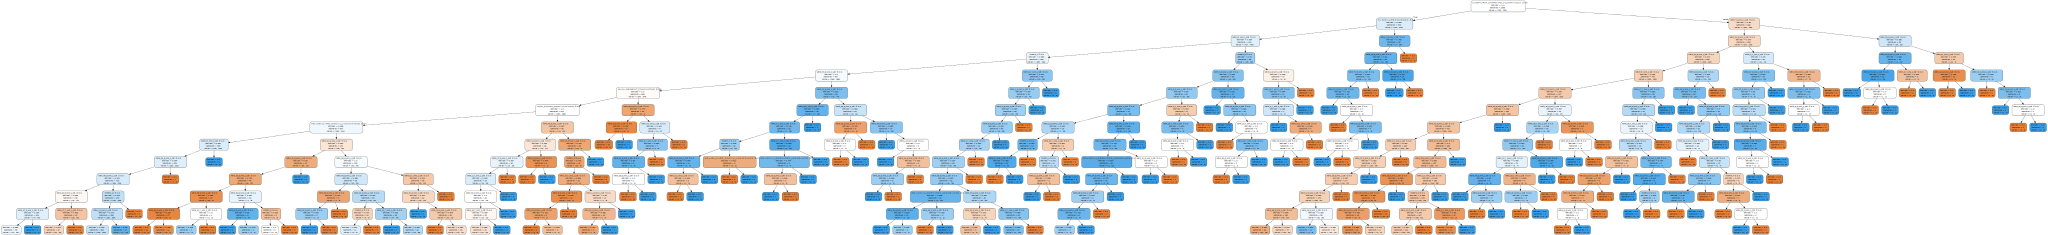

In [175]:
!pip install graphviz

from sklearn.tree import export_graphviz
import graphviz 

dot_data = export_graphviz(tree_grid.best_estimator_, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = export_graphviz(tree_grid.best_estimator_, out_file=None, 
                      feature_names=X_train.columns,
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

Al tener mucha profundidad y muchas variables, la representación queda dispersa. Por ese motivo, hemos dibujado el árbol con 19 variables y 2 capas de profundad.

In [176]:
tree=DecisionTreeClassifier(criterion='entropy',max_depth=2,max_features=19,random_state=17)
tree.fit(X_train, y_train)

predicted = tree.predict(X_train)
predicted1= tree.predict(X_test)
print('RMSE Train: {0:.4f}'.format(rmse(predicted,y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(predicted1,y_test)))
print('Precisión Train: {0:.4f}'.format(tree.score(X_train,y_train)))
print('Precisión Test: {0:.4f}'.format(tree.score(X_test,y_test)))

RMSE Train: 0.6504
RMSE Test: 0.6656
Precisión Train: 0.5769
Precisión Test: 0.5570


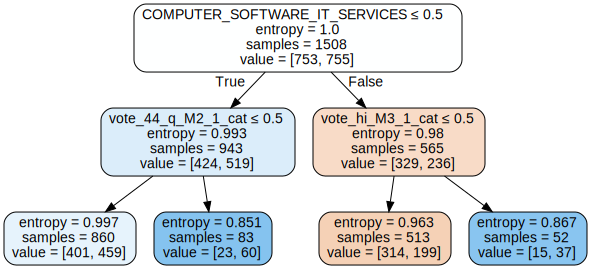

In [177]:
!pip install graphviz

from sklearn.tree import export_graphviz
import graphviz 

dot_data = export_graphviz(tree, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = export_graphviz(tree, out_file=None, 
                      feature_names=X_train.columns,
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

## 4.2. Random Forest

Una vez vemos que el árbol de decisión puede ser un buen método para predecir el estrés sobre los empleados de nuestra muestra, vamos a ver si el Random Forest nos mejora esta predicción.

Para empezar definimos las librerías necesarias.

In [178]:
from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def rmse(x,y):return np.sqrt(((x-y)**2).mean())

Dividimos la muestra en train y test.

In [179]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size =0.2,random_state=17)

Aplicamos método 'RandomForestClassifier' y calculamos los rmse y scores asociados a la predicción.

In [180]:
RF=RandomForestClassifier(n_estimators=200,max_leaf_nodes=50,min_samples_leaf=20,
                         min_samples_split=20,max_depth=70,max_features=0.9,
                         n_jobs=-1,random_state=17)
RF.fit(X_train,y_train)
pred=RF.predict(X_train)
pred1=RF.predict(X_test)
print('RMSE Train: {0:.4f}'.format(rmse(pred,y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(pred1,y_test)))
print('Precisión Train: {0:.4f}'.format(RF.score(X_train,y_train)))
print('Precisión Test: {0:.4f}'.format(RF.score(X_test,y_test)))

RMSE Train: 0.5157
RMSE Test: 0.6223
Precisión Train: 0.7341
Precisión Test: 0.6127


Una vez hemos ajustado manualmente nuestro Random Forest, vamos a construir un GridSearch para ver si encontramos un modelo más preciso. Para limitar el tiempo de ejecución, vamos a utilizar el RandomizedSearchCV que nos permitirá realizar un número determinado de combinaciones sobre todos los parámetros que le indiquemos.

In [181]:
parameters={'max_depth': [50,70,90,110,130,150,200,250,300,500],
 'max_features': ['log2','sqrt',0.5,0.3,0.7],
 'n_estimators': [130,200,350,500],
 'max_leaf_nodes': [int(x) for x in np.linspace(2,300,num=10)],
 'min_samples_leaf': [2,5,10,20,50,70],
 'min_samples_split': [2,5,10,20,40]}

In [182]:
RF1=RandomForestClassifier(random_state=42,n_jobs=-1, oob_score=True)
%time gs=RandomizedSearchCV(RF1,parameters,cv=3,n_iter=20,scoring='neg_mean_squared_error').fit(X_train,y_train)

CPU times: user 50.4 s, sys: 3.45 s, total: 53.8 s
Wall time: 1min 37s


In [183]:
gs.best_estimator_.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=0.7,
                       max_leaf_nodes=233, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [184]:
pred=gs.best_estimator_.predict(X_train)
pred1=gs.best_estimator_.predict(X_test)
print('RMSE Train: {0:.4f}'.format(rmse(pred,y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(pred1,y_test)))
print('Precisión Train: {0:.4f}'.format(gs.best_estimator_.score(X_train,y_train)))
print('Precisión Test: {0:.4f}'.format(gs.best_estimator_.score(X_test,y_test)))

RMSE Train: 0.4332
RMSE Test: 0.6329
Precisión Train: 0.8123
Precisión Test: 0.5995


Vemos como el RandomizedGridSearchCV nos ha permitido mejorar unas décimas nuestro modelo.

###Feature importance

Una de las ventajas de aplicar el Random Forest es que nos permite obtener la importancia de las variables sobre la predicción de la variable objetivo. En este paso intentaremos seleccionar las variables más importantes y crear un modelo más sencillo a partir de ellas y analizaremos su comportamiento.

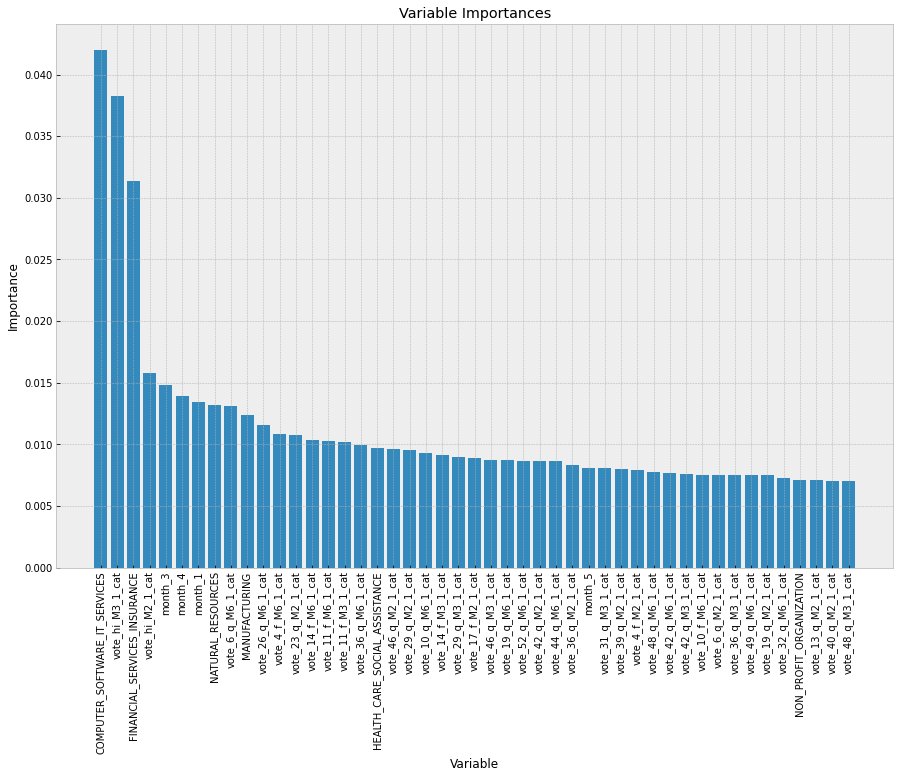

In [186]:
importances=gs.best_estimator_.feature_importances_
feature_list = list(X_train.columns)
feature_importance= sorted(zip(importances, feature_list), reverse=True)
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
plt.style.use('bmh')

# seleccionamos las variables con importancia > 0.0007
df_imp=df[df['importance']>0.007]
x_values = list(range(len(df_imp['importance'])))
plt.figure(figsize=(15,10))
plt.bar(x_values, df_imp['importance'], orientation = 'vertical')
plt.xticks(x_values, df_imp['feature'], rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [187]:
df_imp.head(40)

,importance,feature
0,0.041991,COMPUTER_SOFTWARE_IT_SERVICES
1,0.038260,vote_hi_M3_1_cat
2,0.031361,FINANCIAL_SERVICES_INSURANCE
3,0.015772,vote_hi_M2_1_cat
4,0.014795,month_3
5,0.013956,month_4
6,0.013440,month_1
7,0.013184,NATURAL_RESOURCES
8,0.013153,vote_6_q_M6_1_cat
9,0.012400,MANUFACTURING


Creamos una lista con las variables seleccionadas y aplicamos un 'RandomizedSearchCV' sobre el 'RandomForestClassifier' para obtener el mejor modelo posible con estas variables.

In [188]:
a=list(df_imp['feature'])
X_importance=X_train[a]
X_test_importance=X_test[a]

In [189]:
tree_imp=RandomForestClassifier(random_state=42,n_jobs=-1, oob_score=True)
%time gs_imp=RandomizedSearchCV(tree_imp,parameters,cv=5,n_iter=40,scoring='neg_mean_squared_error').fit(X_importance,y_train)

CPU times: user 1min 55s, sys: 8.57 s, total: 2min 4s
Wall time: 3min 38s


In [190]:
best_tree_imp=gs_imp.best_estimator_
print('RMSE Train: {0:.4f}'.format(rmse(best_tree_imp.predict(X_importance),y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(best_tree_imp.predict(X_test_importance),y_test)))
print('Precisión Train: {0:.4f}'.format(best_tree_imp.score(X_importance,y_train)))
print('Precisión Test: {0:.4f}'.format(best_tree_imp.score(X_test_importance,y_test)))

RMSE Train: 0.5321
RMSE Test: 0.6391
Precisión Train: 0.7168
Precisión Test: 0.5915


El modelo con menos variables no mejora el inicial, por lo que nos decantaremos por utilizar el modelo con todas las variables disponibles.

## 4.3. Regresión logística

A continuación implementamos una regresión logística. De esta forma podremos determinar qué variables son significativas en la predicción con la función logit.

Como una primera aproximación, utilizamos las variables que nos han salido en el análisis de importancia de las variables en el método Random Forest.

In [191]:
x_new=X_train[a]

In [192]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_new)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.642552
         Iterations 5
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.073     
Dependent Variable:     vote_stress_cat      AIC:                  2031.9379 
Date:                   2020-07-12 15:43     BIC:                  2281.9092 
No. Observations:       1508                 Log-Likelihood:       -968.97   
Df Model:               46                   LL-Null:              -1045.3   
Df Residuals:           1461                 LLR p-value:          2.3664e-13
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         5.0000                                               
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------

En el ajuste se observa como hay muchas variables cuyo coeficiente no es significativo (P>|z| > 0.05).

**Modelo 1**

Buscamos combinación de variables que cumplan con la significancia estadística en la regresión logística.

In [231]:
vars_modelo1=['COMPUTER_SOFTWARE_IT_SERVICES', 'vote_hi_M3_1_cat', 'FINANCIAL_SERVICES_INSURANCE',
          'month_3', 'month_1', 'NATURAL_RESOURCES', 'vote_26_q_M6_1_cat', 'vote_17_f_M2_1_cat',
          'vote_44_q_M6_1_cat', 'vote_32_q_M6_1_cat']

x_new_vars1=X_train[vars_modelo1]
x_t_new_vars1=X_test[vars_modelo1]
logit_model=sm.Logit(y_train,x_new_vars1)
result1=logit_model.fit()
print(result1.summary2())

Optimization terminated successfully.
         Current function value: 0.653931
         Iterations 5
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.057     
Dependent Variable:     vote_stress_cat      AIC:                  1992.2551 
Date:                   2020-07-12 16:01     BIC:                  2045.4405 
No. Observations:       1508                 Log-Likelihood:       -986.13   
Df Model:               9                    LL-Null:              -1045.3   
Df Residuals:           1498                 LLR p-value:          3.0129e-21
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         5.0000                                               
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [232]:
prediccion=result1.predict(x_t_new_vars1)
y_predict=list()
for i in prediccion:
  if i>0.5:
    y=1
  else:
    y=0
  y_predict.append(y)
1-sum(abs(y_predict-y_test))/len(y_predict)

0.572944297082228

En este primer modelo encontramos una combinación de variables con una precisión de 0.57

Las variables que entran en la regresión son:

COMPUTER_SOFTWARE_IT_SERVICES*

vote_hi_M3_1_cat

FINANCIAL_SERVICES_INSURANCE

month_3*

month_1

NATURAL_RESOURCES

vote_26_q_M6_1_cat

vote_17_f_M2_1_cat*

vote_44_q_M6_1_cat

vote_32_q_M6_1_cat*

El resultado de la regresión nos da coeficientes negativos para COMPUTER_SOFTWARE_IT_SERVICES, month_3, vote_17_f_M2_1_cat y vote_32_q_M6_1_cat, lo cual significa que el efecto de estas variables es inverso al resto, es decir, que si la variable vale 1, disminuyen las probabilidades de tener estrés.

La relación entre las variables de voto y las preguntas asociadas son:

In [343]:
questions.query('questionNumber== [26,44,32] | factorNumber==17')

,questionNumber,factorNumber,questionTitle,factorName
26,26,9,Do you have the tools and resources you need to do your job?,Environment
32,32,11,For *|COMPANY_NAME|* to celebrate our accomplishments and milestones is:,Recognition
44,44,15,The business goals and strategies set by senior leadership are taking *|COMPANY_NAME|* in the right direction.,Trust & Vision
48,48,17,I see how I can advance in my career at *|COMPANY_NAME|*,Mastery
49,49,17,My job at *|COMPANY_NAME|* enables me to learn and develop new skills,Mastery
50,50,17,My manager (or someone in management) encourages and supports my development,Mastery
51,51,17,I would rate the way *|COMPANY_NAME|* uses my strengths and abilities as:,Mastery


Comprobamos con el método 'LogisticRegression' que el resultado encaja con el obtenido en el método anterior.

In [277]:
from sklearn.linear_model import LogisticRegression
logreg1 = LogisticRegression()
logreg1.fit(x_new_vars1, y_train)
y_pred1 = logreg1.predict(x_t_new_vars1)
print('RMSE Train: {0:.4f}'.format(rmse(logreg1.predict(x_new_vars1),y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(y_pred1,y_test)))
print('Precisión Train: {0:.4f}'.format(logreg1.score(x_new_vars1,y_train)))
print('Precisión Test: {0:.4f}'.format(logreg1.score(x_t_new_vars1,y_test)))

RMSE Train: 0.6196
RMSE Test: 0.6535
Precisión Train: 0.6160
Precisión Test: 0.5729


**Modelo 2**

Probamos otra combinación de variables para ver si tenemos mejor ajuste.

In [233]:
vars_modelo2=['COMPUTER_SOFTWARE_IT_SERVICES', 'FINANCIAL_SERVICES_INSURANCE','month_1', 
          'month_3', 'vote_hi_M6_1_cat','vote_26_q_M6_1_cat','vote_42_q_M2_1_cat',
          'vote_44_q_M6_1_cat']
x_new_vars2=X_train[vars_modelo2]
x_t_new_vars2=X_test[vars_modelo2]
logit_model=sm.Logit(y_train,x_new_vars2)
result2=logit_model.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.663094
         Iterations 5
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.043     
Dependent Variable:     vote_stress_cat      AIC:                  2015.8905 
Date:                   2020-07-12 16:02     BIC:                  2058.4388 
No. Observations:       1508                 Log-Likelihood:       -999.95   
Df Model:               7                    LL-Null:              -1045.3   
Df Residuals:           1500                 LLR p-value:          9.1466e-17
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         5.0000                                               
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [234]:
prediccion=result2.predict(x_t_new_vars2)
y_predict=list()
for i in prediccion:
  if i>0.5:
    y=1
  else:
    y=0
  y_predict.append(y)
1-sum(abs(y_predict-y_test))/len(y_predict)

0.596816976127321

En este caso tenemos otra combinación muy similar a la del modelo 1 pero con alguna otra variable que hace que los coeficientes sean ligeramente diferentes. La combinación es la siguiente:

COMPUTER_SOFTWARE_IT_SERVICES*

FINANCIAL_SERVICES_INSURANCE

month_1

month_3*

vote_hi_M6_1_cat

vote_26_q_M6_1_cat

vote_42_q_M2_1_cat*

vote_44_q_M6_1_cat

La relación de las variables 'vote' con las preguntas es la siguiente:

In [330]:
questions.query('questionNumber== [26,44,42]')

,questionNumber,factorNumber,questionTitle,factorName
26,26,9,Do you have the tools and resources you need t...,Environment
42,42,15,The vision and purpose of *|COMPANY_NAME|* ins...,Trust & Vision
44,44,15,The business goals and strategies set by senio...,Trust & Vision


In [280]:
from sklearn.linear_model import LogisticRegression
logreg2 = LogisticRegression()
logreg2.fit(x_new_vars2, y_train)
y_pred2 = logreg2.predict(x_t_new_vars2)
print('RMSE Train: {0:.4f}'.format(rmse(logreg2.predict(x_new_vars2),y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(y_pred2,y_test)))
print('Precisión Train: {0:.4f}'.format(logreg2.score(x_new_vars2,y_train)))
print('Precisión Test: {0:.4f}'.format(logreg2.score(x_t_new_vars2,y_test)))

RMSE Train: 0.6281
RMSE Test: 0.6371
Precisión Train: 0.6054
Precisión Test: 0.5942


Como vemos, el modelo 2 es ligeramente mejor que el modelo 1, aunque ninguno de los dos supera al Random Forest.

Por último, los modelos de regresión logística nos permiten ver el peso de cada variable sobre el modelo final. Esto nos indica cuánta importancia tiene cada variable sobre la predicción final.

In [306]:
# 1. Calculamos desviación estandar de las variables
a1=np.array(np.std(x_new_vars1))
# 2. Obtenemos los coeficientes
b1=logreg1.coef_[0]
# 3. Estandarizamos los coeficientes
b_est1=b1/a1
# 4. Calculamos los pesos
pesos1=abs(b_est1/abs(b_est1).sum())*100
# 5. Creamos un dataframe para poder representarlos mejor.
df_modelo1=pd.DataFrame({'variable':vars_modelo1,
                        'coeficiente':b1,
                        'peso':pesos1})
df_modelo1

,variable,coeficiente,peso
0,COMPUTER_SOFTWARE_IT_SERVICES,-0.380440,3.924491
1,vote_hi_M3_1_cat,1.073616,18.018807
2,FINANCIAL_SERVICES_INSURANCE,0.486474,6.326560
3,month_3,-0.446396,6.103347
4,month_1,0.476020,8.652147
5,NATURAL_RESOURCES,0.998183,34.583530
6,vote_26_q_M6_1_cat,0.371982,3.904137
7,vote_17_f_M2_1_cat,-0.445883,5.948844
8,vote_44_q_M6_1_cat,0.646318,10.719436
9,vote_32_q_M6_1_cat,-0.171474,1.818702


Vemos como la variable con más peso es NATURAL_RESOURCES (34,5%), seguida del voto de hapiness index 3 meses antes de responder al estrés (18%). El resto de variables se reparten un peso muy similar.

A continuación realizamos el mismo tratamiento para el modelo 2.

In [309]:
# 1. Calculamos desviación estandar de las variables
a2=np.array(np.std(x_new_vars2))
# 2. Obtenemos los coeficientes
b2=logreg2.coef_[0]
# 3. Estandarizamos los coeficientes
b_est2=b2/a2
# 4. Calculamos los pesos
pesos2=abs(b_est2/abs(b_est2).sum())*100
# 5. Creamos un dataframe para poder representarlos mejor.
df_modelo2=pd.DataFrame({'variable':vars_modelo2,
                        'coeficiente':b_est2,
                        'peso':pesos2})
df_modelo2

,variable,coeficiente,peso
0,COMPUTER_SOFTWARE_IT_SERVICES,-0.869299,7.998954
1,FINANCIAL_SERVICES_INSURANCE,1.184922,10.903188
2,month_1,1.943038,17.879076
3,month_3,-1.129062,10.389189
4,vote_hi_M6_1_cat,2.764627,25.439019
5,vote_26_q_M6_1_cat,0.700872,6.449149
6,vote_42_q_M2_1_cat,-0.386649,3.557791
7,vote_44_q_M6_1_cat,1.889195,17.383635


En este caso la variable más importante es el voto del hapiness index 6 meses antes (25,4%) seguida de si el voto se realiza en enero (17,87%) y de la pregunta 44 6 meses antes (objetivos y estrategia del manager) (17.38%)

In [346]:
questions.query('questionNumber== [26,44,42]')

,questionNumber,factorNumber,questionTitle,factorName
26,26,9,Do you have the tools and resources you need to do your job?,Environment
42,42,15,The vision and purpose of *|COMPANY_NAME|* inspires me.,Trust & Vision
44,44,15,The business goals and strategies set by senior leadership are taking *|COMPANY_NAME|* in the right direction.,Trust & Vision


In [349]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred1)

array([[119,  70],
       [ 91,  97]])

In [350]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.57      0.63      0.60       189
           1       0.58      0.52      0.55       188

    accuracy                           0.57       377
   macro avg       0.57      0.57      0.57       377
weighted avg       0.57      0.57      0.57       377



In [351]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred2)

array([[116,  73],
       [ 80, 108]])

In [353]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       189
           1       0.60      0.57      0.59       188

    accuracy                           0.59       377
   macro avg       0.59      0.59      0.59       377
weighted avg       0.59      0.59      0.59       377



# Cluster

### Preparación del modelo

In [ ]:
""" En primer lugar, vamos a jugar con el dataset sin categorizar preparar el dataset, 
 eliminando todo aquello que no nos interese.
 """

df_clustering = pd.get_dummies(big_df.drop(['employeeId', 'companyAlias', 'date_stress'], axis=1))


# Aprovechando que tenemos un dataframe con las features mas importantes, vamos a seleccionarlas en el nuestro:
a=list(df_imp['feature'])

relevant_features = list(df_imp.filter(regex='q'))


df_clustering.fillna(5, inplace=True) 
y_clustering=df_clustering.pop('vote_stress')
scaler = StandardScaler()
df_clustering = pd.DataFrame(scaler.fit_transform(df_clustering),  columns = df_clustering.columns)
X_clustering = df_clustering



In [ ]:




""" Vamos a intentar rellenar los NA de forma inteligente.
#df_clustering = df_clustering[df_clustering.columns.drop(list(df_clustering.filter(regex='q')))]


for i in range(5, 8):
  # Vamos a pillar todas las columnas del factor
  df_selected_columns = df_clustering.filter(regex='vote_{}_f'.format(i))
  # Solo aquellas donde hay nulos
  df_clustering_null = df_selected_columns[pd.isnull(df_selected_columns).any(axis=1)]
  df_clustering['vote_{}_f'.format(i)].fillna() = df_clustering_null.mean(axis=1)



df_clustering.isna().sum()


df_clustering.head()


df_clustering.fillna(5, inplace=True) 
y_clustering=df_clustering.pop('vote_stress')
scaler = StandardScaler()
df_clustering = pd.DataFrame(scaler.fit_transform(df_clustering),  columns = df_clustering.columns)
X_clustering = df_clustering

"""

In [ ]:
#Vamos a ver la dimensionalidad:
X_clustering.head()

,vote_hi_M6_1,vote_hi_M3_1,vote_hi_M2_1,vote_0_q_M2_1,vote_0_q_M3_1,vote_0_q_M6_1,vote_1_q_M2_1,vote_1_q_M3_1,vote_1_q_M6_1,vote_2_q_M2_1,vote_2_q_M3_1,vote_2_q_M6_1,vote_3_q_M2_1,vote_3_q_M3_1,vote_3_q_M6_1,vote_4_q_M2_1,vote_4_q_M3_1,vote_4_q_M6_1,vote_5_q_M2_1,vote_5_q_M3_1,vote_5_q_M6_1,vote_6_q_M2_1,vote_6_q_M3_1,vote_6_q_M6_1,vote_7_q_M2_1,vote_7_q_M3_1,vote_7_q_M6_1,vote_8_q_M2_1,vote_8_q_M3_1,vote_8_q_M6_1,vote_9_q_M2_1,vote_9_q_M3_1,vote_9_q_M6_1,vote_10_q_M2_1,vote_10_q_M3_1,vote_10_q_M6_1,vote_11_q_M2_1,vote_11_q_M3_1,vote_11_q_M6_1,vote_12_q_M2_1,...,vote_10_f_M3_1,vote_10_f_M6_1,vote_11_f_M2_1,vote_11_f_M3_1,vote_11_f_M6_1,vote_12_f_M2_1,vote_12_f_M3_1,vote_12_f_M6_1,vote_13_f_M2_1,vote_13_f_M3_1,vote_13_f_M6_1,vote_14_f_M2_1,vote_14_f_M3_1,vote_14_f_M6_1,vote_15_f_M2_1,vote_15_f_M3_1,vote_15_f_M6_1,vote_16_f_M2_1,vote_16_f_M3_1,vote_16_f_M6_1,vote_17_f_M2_1,vote_17_f_M3_1,vote_17_f_M6_1,vote_18_f_M2_1,vote_18_f_M3_1,vote_18_f_M6_1,companyIndustry_ACCOMMODATION_AND_FOOT_SERVICES,companyIndustry_ARTS_ENTERTAINMENT_RECREATION,companyIndustry_COMPUTER_SOFTWARE_IT_SERVICES,companyIndustry_EDUCATIONAL_SERVICES,companyIndustry_FINANCIAL_SERVICES_INSURANCE,companyIndustry_HEALTH_CARE_SOCIAL_ASSISTANCE,companyIndustry_MANAGEMENT_CONSULTING,companyIndustry_MANUFACTURING,companyIndustry_MARKETING_ADVERTISING,companyIndustry_NATURAL_RESOURCES,companyIndustry_NON_PROFIT_ORGANIZATION,companyIndustry_PUBLIC_AND_GOVERMENT_ADMINISTRATION,companyIndustry_UTILITIES_AND_SERVICES,companyIndustry_WHOLESALE_AND_RETAIL_TRADE
0,0.021975,0.049103,0.051764,0.052312,-0.074280,-0.224437,-0.662876,-0.710413,-0.764348,-0.549501,-0.571386,-0.589976,0.824813,0.881572,0.939574,-0.607017,-0.632889,-0.665807,0.814892,0.727864,0.662318,-0.652722,-0.568683,-0.458463,1.392401,1.307334,1.247644,0.799371,0.730968,0.681722,0.744716,0.670525,0.613742,0.703250,0.731694,0.797753,-0.578001,-0.602643,-0.648498,0.874674,...,-0.129408,-0.142341,0.363610,0.378820,0.402577,1.186979,1.098322,0.985622,-0.589269,-0.627160,-0.671227,0.315304,0.328511,0.383277,-0.666553,-0.694057,-0.736169,-0.262988,-0.281969,-0.313385,-0.433634,-0.440877,-2.069027,-0.679066,-0.713742,-0.766631,-0.222609,-0.046114,-0.769455,-0.129308,-0.464053,2.330976,-0.137546,-0.320912,-0.051571,-0.14535,-0.239180,-0.122793,-0.089562,-0.133486
1,-0.271532,0.049103,0.051764,-0.896610,-1.015042,-1.189785,-0.662876,-0.710413,-0.764348,-0.549501,-0.571386,-0.589976,0.824813,0.881572,0.939574,-0.607017,-0.632889,-0.665807,-0.620167,-0.661683,-0.696930,0.911819,0.993573,1.107357,-0.597435,-0.627303,-0.657619,-0.567664,-0.602137,-0.634699,-0.841985,-0.904478,-0.967447,0.703250,0.731694,0.797753,-0.578001,-0.602643,-0.648498,0.874674,...,-0.129408,-0.142341,0.363610,0.378820,0.402577,0.681168,0.594468,0.489499,-0.589269,-0.627160,-0.671227,0.315304,0.328511,0.383277,0.339668,0.297137,0.240648,-0.536388,-0.552873,-0.583893,-0.433634,-0.440877,-0.456858,-0.679066,-0.713742,-0.766631,-0.222609,-0.046114,-0.769455,-0.129308,-0.464053,-0.429005,-0.137546,-0.320912,-0.051571,-0.14535,4.180956,-0.122793,-0.089562,-0.133486
2,-0.158645,-0.125600,-0.133039,1.001235,0.866483,0.740911,1.299209,1.199672,1.113216,1.491670,1.417802,1.370687,-1.132312,-1.049214,-0.987975,0.788381,0.725567,0.657430,1.054069,0.959455,0.888859,-1.043857,-0.959248,-0.849917,0.894942,0.823675,0.771328,0.799371,0.730968,0.681722,0.744716,0.670525,0.613742,-0.630378,-0.580205,-0.484411,1.121990,1.065233,0.974284,-0.563617,...,-0.129408,-0.142341,0.363610,0.378820,0.402577,-0.836265,-0.917095,-0.998870,-0.589269,-0.627160,-0.671227,0.315304,0.328511,0.383277,0.004261,-0.033261,-0.084958,-0.536388,-0.552873,-0.583893,-0.433634,-0.440877,-0.456858,0.720661,0.665705,0.601893,-0.222609,-0.046114,1.299621,-0.129308,-0.464053,-0.429005,-0.137546,-0.320912,-0.051571,-0.14535,-0.239180,-0.122793,-0.089562,-0.133486
3,-0.384419,-0.383287,-0.266507,-0.896610,-1.015042,0.258237,-0.662876,-0.710413,-0.764348,-0.549501,-0.571386,-0.589976,0.824813,0.881572,0

In [ ]:
# Vamos a hacer el split:

X_train_clustering, X_test_clustering, y_train_clustering,y_test_clustering = train_test_split(X_clustering, y_clustering, test_size = 0.4,random_state=17)


[]

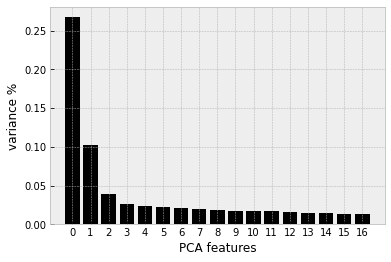

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Vamos a ver si podemos reducir la dimensionalidad del set
pca = PCA(n_components=17)
model = pca.fit(X_train_clustering)
principalComponents = pca.transform(X_train_clustering)

pca.explained_variance_ratio_


# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.plot()


**Mala pinta:** esto nos dice que los componentes que ha podido crear explican poco. Por ejemplo, el PCA0, solo explica el 25% de los casos, el PCA1, no llega ni al 11%. A partir de ahi, todo decae.

Esto nos indica, que el clustering probablemente no sea un buen metodo para el modelo.*texto en cursiva*

In [ ]:
# Ok, vamos a ver cual es la feature mas importante por cada componente, a ver si podemos rascar algo

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(pca.n_components_)]
initial_feature_names = df_clustering.columns.values.tolist()


most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.n_components_)]


# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(pca.n_components_)}

# build the dataframe
pd.DataFrame(sorted(dic.items())).head(20)




,0,1
0,PC0,vote_6_f_M6_1
1,PC1,vote_12_q_M3_1
2,PC10,vote_5_f_M6_1
3,PC11,vote_27_q_M3_1
4,PC12,vote_18_f_M3_1
5,PC13,vote_9_f_M3_1
6,PC14,vote_40_q_M6_1
7,PC15,vote_38_q_M2_1
8,PC16,vote_0_q_M3_1
9,PC2,vote_3_f_M6_1


[]

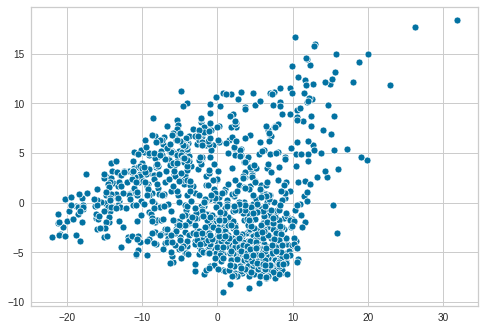

In [ ]:
# Entrenar PCA para representar
pca =  PCA(n_components=17)     # metodo de sklearn 
pca.fit(X_train_clustering)
X_pca = pca.transform(X_train_clustering)

# Representar cin los clusters como color 
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=kmeans.labels_).plot()


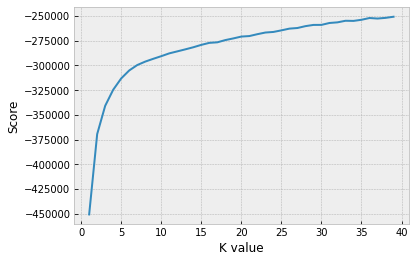

In [ ]:
# Vamos a buscar el codo...
import matplotlib.pyplot as plt
scores = []
k_values = range(1,40)
for a in k_values:
    
    # Definir Kmeans y ajustar
    model = KMeans(n_clusters= a).fit(df_clustering)
    # Guardar la predicción
    scores.append(model.score(df_clustering))
        
plt.plot(k_values, scores)
plt.xlabel('K value')
plt.ylabel('Score')
plt.show()

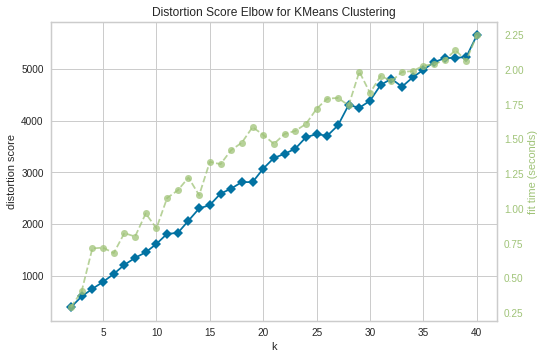

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.datasets import make_blobs

eb_model = KElbowVisualizer(KMeans(), k=40, metric='distortion')
eb_model.fit(df_clustering)
eb_model.poof()

**Pero que movida es esta xDDD**

In [ ]:
# Dificil ver cuantos clusters elegir. Por que yo lo valgo, decido que 5, que parece mas arriba que es donde empezamos a aplanar la curva...

# Tal y como hemos visto, 4 clussters parece lo adecuado:

model = KMeans(n_clusters= 5).fit(df_clustering)

print(scaler.inverse_transform(model.cluster_centers_))

# Vamos a preparar los centros para representarlos: tenemos que transponer la matriz de puntos para poder trabajar con el scatter
centroids = np.transpose(scaler.inverse_transform(model.cluster_centers_))


[[ 2.97734433e+00  2.96136744e+00  2.95870245e+00 ...  4.09836066e-03
   8.19672131e-03  1.14491749e-16]
 [ 2.96584177e+00  2.94366191e+00  2.94624397e+00 ...  3.16546763e-02
   1.29496403e-02  4.74820144e-02]
 [ 3.00658476e+00  2.99923922e+00  2.99593055e+00 ... -3.29597460e-17
   6.93889390e-18 -3.81639165e-17]
 [ 3.47727761e+00  3.46602817e+00  3.46139045e+00 ...  2.99401198e-03
  -4.16333634e-17  5.20417043e-17]
 [ 2.10637250e+00  2.05979227e+00  2.04696726e+00 ...  1.74418605e-02
   1.16279070e-02 -2.08166817e-17]]
